In [4]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_validate, StratifiedKFold
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import (
        roc_auc_score, average_precision_score, precision_recall_curve, roc_curve,
        confusion_matrix, accuracy_score, f1_score, classification_report)

In [5]:
TARGET = "Label" # 1=attack, 0=normal
RANDOM_STATE = 42

In [6]:
clearData = pd.read_csv("C:\\Users\\Gökhan\\Desktop\\nids-adversarial\\data\\without_Attack_cat_clear_data_full.csv", low_memory=False)

In [7]:
clearData.shape

(2540026, 42)

In [8]:
clearData.head(10)

,sport,dsport,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,...,ct_state_ttl,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,Label
0,33661,1024,udp,CON,0.036133,528,304,31,29,0,...,0,0,2,4,2,3,1,1,2,0
1,1464,53,udp,CON,0.001119,146,178,31,29,0,...,0,0,12,8,1,2,2,1,1,0
2,3593,53,udp,CON,0.001209,132,164,31,29,0,...,0,0,6,9,1,1,1,1,1,0
3,49664,53,udp,CON,0.001169,146,178,31,29,0,...,0,0,7,9,1,1,1,1,1,0
4,32119,111,udp,CON,0.078339,568,312,31,29,0,...,0,0,2,4,2,3,1,1,2,0
5,2142,53,udp,CON,0.001134,132,164,31,29,0,...,0,0,12,7,1,2,2,1,1,0
6,0,0,arp,INT,0.000000,46,0,0,0,0,...,2,0,2,2,2,2,2,2,2,0
7,40726,53,udp,CON,0.001126,146,178,31,29,0,...,0,0,6,7,3,1,1,1,1,0
8,12660,53,udp,CON,0.001167,132,164,31,29,0,...,0,0,6,7,2,1,1,1,1,0
9,0,0,arp,INT,0.000000,46,0,0,0,0,...,2,0,2,2,2,2,2,2,2,0


In [15]:
# # X'e hedefi ve varsa 'label'ı ALMA (label -> leakage)
drop_cols = [TARGET]
if 'Label' in clearData.columns:
    drop_cols.append('Label')
X = clearData.drop(columns=drop_cols)
y = clearData[TARGET]
    
# %80 / %20 split (stratified)\n",
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42, shuffle=True
)
print("Train class dist:", y_train.value_counts(normalize=True).round(3))
print("Test class dist:", y_test.value_counts(normalize=True).round(3))

Train class dist: Label
0    0.874
1    0.126
Name: proportion, dtype: float64
Test class dist: Label
0    0.874
1    0.126
Name: proportion, dtype: float64


In [16]:
X_train.shape

(2032020, 41)

In [17]:
y_train.shape

(2032020,)

In [18]:
X_test.shape

(508006, 41)

In [19]:
y_test.shape

(508006,)

In [11]:
# 2) Kolon tiplerini belirleyelim
# Sayısal/kategorik ayrımı: object ve category -> kategorik; geri kalan -> sayısal varsayımı
def split_columns(X_train, target):
    cols = [c for c in X_train.columns if c != target]
    cat_cols = []
    num_cols = []

    for c in cols:
        if X_train[c].dtype.name in ["object", "category"]:
            cat_cols.append(c)
        else:
            # Çok-unique ve sayısal görünümlü object'ler varsa dönüştürmeyi düşünebilirsiniz.
            num_cols.append(c)

    return num_cols, cat_cols

num_cols, cat_cols = split_columns(X_train, TARGET)
print("Numeric:", len(num_cols), "\nCategorical:", len(cat_cols))


Numeric: 38 
Categorical: 3


In [12]:
print("Categorical features:", cat_cols)


Categorical features: ['proto', 'state', 'ct_ftp_cmd']


port numaralarını int e çevir sonra öyle dene. Protocol için erdinin kodlarına bak. is_udp = 1/0 gibi , 

manuel yapalım bunu erdiden bakarsın

In [13]:
# Counting the unique values of the categorical features...

for col_name in X_train.columns:
    if X_train[col_name].dtypes == 'object':
        unique_cat = len(X_train[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} unique values.".format(col_name = col_name, unique_cat = unique_cat))

Feature 'proto' has 134 unique values.
Feature 'state' has 15 unique values.
Feature 'ct_ftp_cmd' has 9 unique values.


In [14]:
def normalize_col(s: pd.Series):
    return s.astype(str).str.lower().str.strip().fillna("unknown")

def pick_top_categories(s: pd.Series, k=6):
    return normalize_col(s).value_counts().head(k).index.tolist()

def add_binary_flags(df: pd.DataFrame, col: str, keep: list, add_other=True, drop_original=True):
    s = normalize_col(df[col])
    for cat in keep:
        new_col = f"is_{col}_{cat}"
        df[new_col] = (s == cat).astype("uint8")
    if add_other:
        df[f"is_{col}_other"] = (~s.isin(keep)).astype("uint8")
    if drop_original:
        df.drop(columns=[col], inplace=True)
    return df

In [15]:
top_proto = pick_top_categories(X_train['proto'], k=6)

X_train = add_binary_flags(X_train, 'proto', top_proto, add_other=True, drop_original=True)
X_test  = add_binary_flags(X_test,  'proto', top_proto, add_other=True, drop_original=True)

In [16]:
top_state = pick_top_categories(X_train['state'], k = 6)

X_train = add_binary_flags(X_train, 'state', top_state, add_other=True, drop_original=True)
X_test  = add_binary_flags(X_test,  'state', top_state, add_other=True, drop_original=True)

In [17]:
top_ct = pick_top_categories(X_train['ct_ftp_cmd'], k = 6)

X_train = add_binary_flags(X_train, 'ct_ftp_cmd', top_ct, add_other=True, drop_original=True)
X_test  = add_binary_flags(X_test,  'ct_ftp_cmd', top_ct, add_other=True, drop_original=True)

In [18]:
X_train.head(10)

,sport,dsport,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,Sload,...,is_state_rst,is_state_eco,is_state_other,is_ct_ftp_cmd_,is_ct_ftp_cmd_0,is_ct_ftp_cmd_1,is_ct_ftp_cmd_2,is_ct_ftp_cmd_4,is_ct_ftp_cmd_3,is_ct_ftp_cmd_other
1867721,47097,80,1.159792,1684,10168,31,29,3,5,1.078814e+04,...,0,0,0,1,0,0,0,0,0,0
190212,17094,40614,0.003643,320,1846,31,29,1,2,5.863299e+05,...,0,0,0,0,1,0,0,0,0,0
2457249,37333,17497,0.128931,5486,95164,31,29,7,42,3.368623e+05,...,0,0,0,1,0,0,0,0,0,0
155190,14035,53,0.001036,146,178,31,29,0,0,5.637066e+05,...,0,0,0,0,1,0,0,0,0,0
1106780,8568,53,0.001123,146,178,31,29,0,0,5.200356e+05,...,0,0,0,1,0,0,0,0,0,0
404031,27374,61307,0.017927,2542,23278,31,29,7,14,1.106264e+06,...,0,0,0,0,1,0,0,0,0,0
1616708,37672,21,1.219942,1076,1638,62,252,7,9,6.708516e+03,...,0,0,0,0,0,1,0,0,0,0
1048895,53862,6881,0.402975,1540,1644,31,29,4,4,2.866679e+04,...,0,0,0,0,1,0,0,0,0,0
1121825,20516,62923,0.306402,4376,2976,31,29,7,7,1.098687e+05,...,0,0,0,1,0,0,0,0,0,0
2484235,6994,5022,0.019854,2542,21450,31,29,7,14,9.988919e+05,...,0,0,0,1,0,0,0,0,0,0


In [ ]:
"""bu statelerin isimlerini not et"""

In [ ]:
"""other_cat = [c for c in cat_cols if c not in ['sport', 'dsport']]

sport_ohe = OneHotEncoder(
    handle_unknown='infrequent_if_exist',   # görülmeyen + nadirleri tek kovaya at
    max_categories=50,                      # en sık 50 kategori ayrı
    min_frequency=25,                       # 25'den az görülenler "other" kovasına
    dtype=np.float32,
    sparse_output=True,
)
dsport_ohe = OneHotEncoder(
    handle_unknown='infrequent_if_exist',
    max_categories=150,
    min_frequency=50,                       # 50'den az görülenler "other" kovasına
    sparse_output=True,
    dtype=np.float32,
)
other_ohe = OneHotEncoder(
    handle_unknown='ignore',
    min_frequency=5,
    sparse_output=True,
    dtype=np.float32
)"""
"""preprocessor = ColumnTransformer(
    transformers=[
        ('num',   'passthrough', num_cols),
    ],
    remainder='drop',
    verbose_feature_names_out=False
)"""


In [20]:
#All DATA
clearData["Label"].value_counts()                            # adet
clearData["Label"].value_counts(normalize=True).mul(100)     # %

Label
0    87.351192
1    12.648808
Name: proportion, dtype: float64

In [21]:
# TRAIN
clearData.loc[X_train.index, "Label"].value_counts()
clearData.loc[X_train.index, "Label"].value_counts(normalize=True).mul(100)


Label
0    87.351207
1    12.648793
Name: proportion, dtype: float64

In [22]:
# TEST
clearData.loc[X_test.index, "Label"].value_counts()
clearData.loc[X_test.index, "Label"].value_counts(normalize=True).mul(100)

Label
0    87.351134
1    12.648866
Name: proportion, dtype: float64

In [23]:
rf_params = dict(
    class_weight='balanced',
    max_depth=30,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=300,
    max_features='sqrt',
    bootstrap=True,
    max_samples=0.8,   
)

model = Pipeline([
    ("preprocessor", preprocessor),
    ("rf", RandomForestClassifier(random_state=42, n_jobs=-1, **rf_params)),
])


In [24]:
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [25]:
def perform_cross_validation(model, X_train, y_train, cv=5):
  
    # Setup cross-validation strategy
    cv_strategy = StratifiedKFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)
    
    # Define scoring metrics
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision_macro',
        'recall': 'recall_macro',
        'f1': 'f1_macro'
    }
    # Perform cross-validation
    cv_results = cross_validate(
        model,
        X_train,
        y_train,
        cv=cv_strategy,
        scoring=scoring,
        return_train_score=True,
        n_jobs=-1,
    )
    # Print results summary
    print("\nCross-Validation Results (Mean ± Std):")
    print("-" * 50)
    for metric in scoring.keys():
        train_scores = cv_results[f'train_{metric}']
        val_scores = cv_results[f'test_{metric}']
        print(f"{metric:12} | Train: {train_scores.mean():.4f} ± {train_scores.std():.4f} | "
              f"Val: {val_scores.mean():.4f} ± {val_scores.std():.4f}")

    return cv_results

In [26]:
param_grid_small = {
    'rf__n_estimators': [300, 500],
    'rf__max_depth': [20, 30],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2],
    'rf__class_weight': ['balanced']
}

grid_search = GridSearchCV(
    model,
    param_grid_small,
    cv=cv_strategy,
    scoring='f1_macro',   # multiclass için
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

In [ ]:
# Use before final model training
print("\n=== Performing Cross-Validation ===")
#model.set_params(**rf_params) #  Set best parameters from grid search
cv_results = perform_cross_validation(model, X_train, y_train, cv=5)


=== Performing Cross-Validation ===


In [ ]:
# Now train final model
print("\n=== Training Final Model ===")
model.fit(X_train, y_train)


=== Training Final Model ===


,steps,"[('preprocessor', ...), ('rf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [ ]:
# 1) Train üzerinde tahmin
y_pred_tr = model.predict(X_train)

# 2) Tipleri hizala (gerekirse)
# Örn. biri string biri int ise ikisini de string yap:
y_true = y_train.astype(str)
y_pred = y_pred_tr.astype(str) if isinstance(y_pred_tr, np.ndarray) else y_pred_tr


# 3) Metrikler
train_f1  = f1_score(y_true, y_pred, average='macro', zero_division=0)
train_acc = accuracy_score(y_true, y_pred)

print("Train F1-macro:", round(train_f1, 4))
print("Train Acc:", round(train_acc, 4))
print(classification_report(y_true, y_pred, zero_division=0))

Train F1-macro: 0.9992
Train Acc: 0.9996
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1774994
           1       1.00      1.00      1.00    257026

    accuracy                           1.00   2032020
   macro avg       1.00      1.00      1.00   2032020
weighted avg       1.00      1.00      1.00   2032020



Test Set Evaluation Results

Classification Report:

              precision    recall  f1-score   support

  Normal (0)       1.00      1.00      1.00    443749
  Attack (1)       0.98      0.98      0.98     64257

    accuracy                           1.00    508006
   macro avg       0.99      0.99      0.99    508006
weighted avg       1.00      1.00      1.00    508006


Confusion Matrix:

[[442670   1079]
 [  1058  63199]]


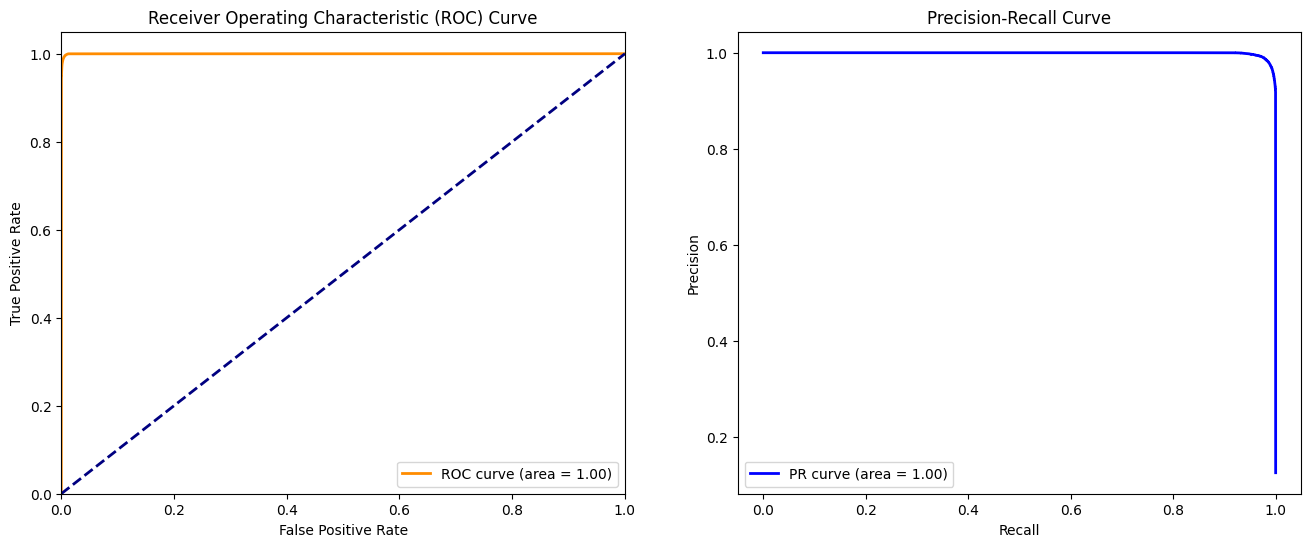

In [ ]:
# --- 1) Make Predictions on the Test Set ---
# Predict class labels (0 or 1)
y_pred_test = model.predict(X_test)

# Predict probabilities for the positive class (attack) for curve plotting
y_pred_proba = model.predict_proba(X_test)[:, 1]


# --- 2) Generate Classification Report ---
print("="*50)
print("Test Set Evaluation Results")
print("="*50)
print("\nClassification Report:\n")
# The report shows the main classification metrics on a per-class basis
print(classification_report(y_test, y_pred_test, target_names=['Normal (0)', 'Attack (1)']))


# --- 3) Display Confusion Matrix ---
print("\nConfusion Matrix:\n")
# The confusion matrix visualizes the performance of the algorithm

cm = confusion_matrix(y_test, y_pred_test)
print(cm)

# --- 4) Plot ROC and Precision-Recall Curves ---
# Calculate AUC scores
roc_auc = roc_auc_score(y_test, y_pred_proba)
pr_auc = average_precision_score(y_test, y_pred_proba)

# Get curve data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot ROC Curve
ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
ax1.legend(loc="lower right")

# Plot Precision-Recall Curve
ax2.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')
ax2.legend(loc="lower left")

plt.show()